# Connect the EIA923 plant_state with the FERC1 respondent_id
### &
# Determine Midwest Purchase Power Prices

In [1]:
import sys
import os
import numpy as np
import pandas as pd
sys.path.append(os.path.abspath(os.path.join('..','..')))
from pudl import pudl, ferc1, eia923
from pudl import models, models_ferc1, models_eia923
from pudl import settings, constants
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pudl_engine  = pudl.connect_db()


## Connecting the EIA923 plant_state with the FERC1 respondent_id

### Pull in all the tables required to associate the EIA923 plant_state with the FERC1 respndent_id.

In [3]:
plants_eia = pd.read_sql('''SELECT * FROM plants_eia''', pudl_engine)

plant_state_eia923 = pd.read_sql('''SELECT plant_id, plant_state \
                            FROM plants_eia923''', pudl_engine)

utility_ids_ferc1 = pd.read_sql('''SELECT * FROM utilities_ferc''', pudl_engine)
utility_ids_ferc1.rename(columns={'util_id_pudl': 'utility_id_pudl'},
                  inplace=True)

util_plant_assn_pudl = pd.read_sql('''SELECT utility_id, plant_id \
                            FROM util_plant_assn''', pudl_engine)
util_plant_assn_pudl.rename(columns={'plant_id': 'plant_id_pudl', 'utility_id': 'utility_id_pudl'},
                  inplace=True)

### Merge these tables
    from plant_state/plant_id 
    to plant_state/operator_id 
    to plant_state/operator_id/utility_id_pudl 
    to plant_state/utility_id_pudl/respondent_id

In [4]:
plants_eia_compiled = plants_eia.merge(plant_state_eia923, on='plant_id',
                                                        how='left')

utility_state_assn = plants_eia_compiled.merge(util_plant_assn_pudl, on='plant_id_pudl',
                                                        how='left')

utility_state_assn.drop_duplicates(['utility_id_pudl', 'plant_state'], inplace=True)
utility_state_assn = utility_state_assn[['utility_id_pudl', 'plant_state']] 

utility_state_assn_ferc1 = utility_state_assn.merge(utility_ids_ferc1[['utility_id_pudl', 'respondent_id']], 
                                                    on='utility_id_pudl', how='left')

## Purchased Power table
Pull in the purchased power table. Then merge the plant_state on the respondent_id.

In [5]:
purchased_power_ferc1 = pd.read_sql('''SELECT *\
                            FROM purchased_power_ferc1''', pudl_engine)

In [6]:
purchased_power_ferc1_states = purchased_power_ferc1.merge(utility_state_assn_ferc1, on='respondent_id', how='left')
purchased_power_ferc1_states = purchased_power_ferc1_states[purchased_power_ferc1_states.mwh_purchased != 0]
purchased_power_ferc1_states['calculated_cost_per_mwh'] = \
((purchased_power_ferc1_states['settlement_total'])/(purchased_power_ferc1_states['mwh_purchased']))

#### Determine which statistical_classification contains wind

In [7]:
mask = purchased_power_ferc1_states['authority_company_name'].str.contains('Wind|Renew|Solar')
zc = purchased_power_ferc1_states[mask]
stat_class = zc.statistical_classification.drop_duplicates()
for stat in stat_class:
    print(stat, len(zc[zc.statistical_classification == stat]))

LF 134
IU 20
OS 732
LU 2295
SF 235
AD 77


In [8]:
for stat in stat_class:
    print(stat, len(purchased_power_ferc1_states[purchased_power_ferc1_states.statistical_classification == stat]))

LF 2057
IU 1265
OS 24014
LU 18048
SF 16935
AD 2261


## Missouri

Sort for only purchased power associated with Missouri. Sort only

In [9]:
ppa_mo = purchased_power_ferc1_states[purchased_power_ferc1_states.plant_state == 'IA']
mask = ppa_mo['authority_company_name'].str.contains('Wind|Renew|Nextera')
renew = ppa_mo[mask]

### Graph Missouri Purchased Power

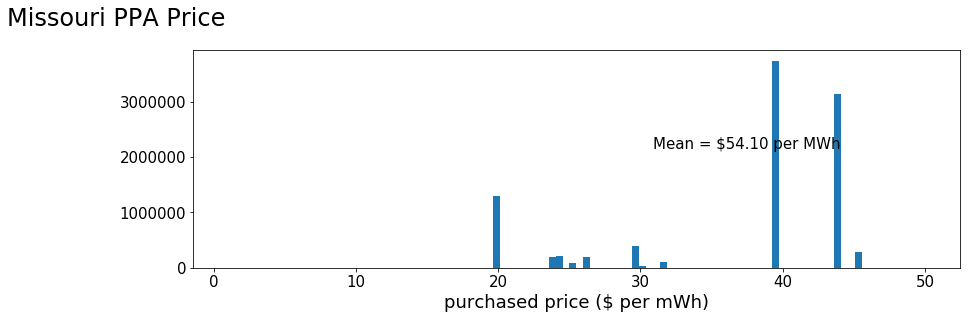

In [10]:
f, (ax1) = plt.subplots(1)
ax1.hist(renew.calculated_cost_per_mwh,bins=100, range=(1,50), weights=renew.mwh_purchased)
ax1.set_xlabel('purchased price ($ per mWh)', size=18)
ax1.yaxis.set_tick_params(labelsize=15)
ax1.xaxis.set_tick_params(labelsize=15)
ax1.text(.6, .55, 'Mean = ${:.2f} per MWh'.format(renew.calculated_cost_per_mwh.mean()), transform=ax1.transAxes, size=15)
plt.text(-0.1, 1.2,'Missouri PPA Price', ha='center', 
         va='top', transform=ax1.transAxes, fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=15)
f.subplots_adjust(left=None, bottom=None, right=1.9, top=None, wspace=None, hspace=None)
plt.show()

## Midwest States

In [11]:
midwest_states = ['MO','NE','IA','IL','AR','OK','KA']
ppa_midwest = pd.DataFrame()
for state in midwest_states:
    ppa_state = purchased_power_ferc1_states[(purchased_power_ferc1_states.plant_state == state)]
    ppa_midwest = ppa_midwest.append(ppa_state)
mask = ppa_midwest['authority_company_name'].str.contains('Wind|Renew|Nextera')
renew_midwest = ppa_midwest[mask]

In [13]:
renew_midwest.to_csv('./midwest_purchased_power.csv', index=False)

### Graph the total region purchased power

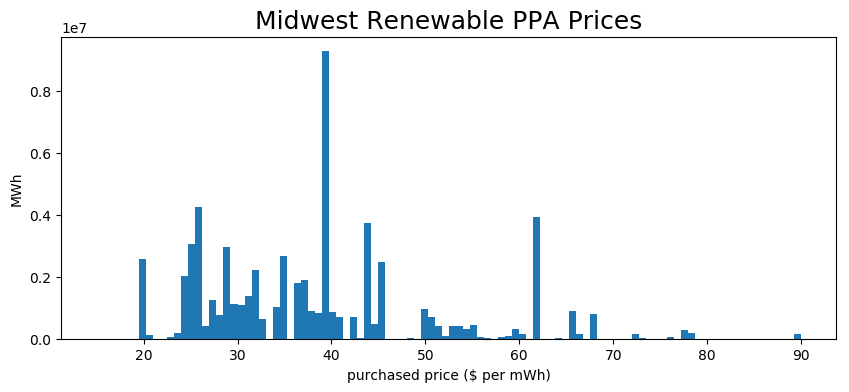

In [14]:
f, (ax1) = plt.subplots(1, dpi=100)
f.set_figwidth(10)
f.set_figheight(4)
ax1.hist(renew_midwest.calculated_cost_per_mwh,bins=100, range=(15,90), weights=renew_midwest.mwh_purchased)
ax1.set_xlabel('purchased price ($ per mWh)')
ax1.set_ylabel('MWh')
ax1.set_title('Midwest Renewable PPA Prices', size=18)
plt.show()

### Graph the yearly purchases for this region

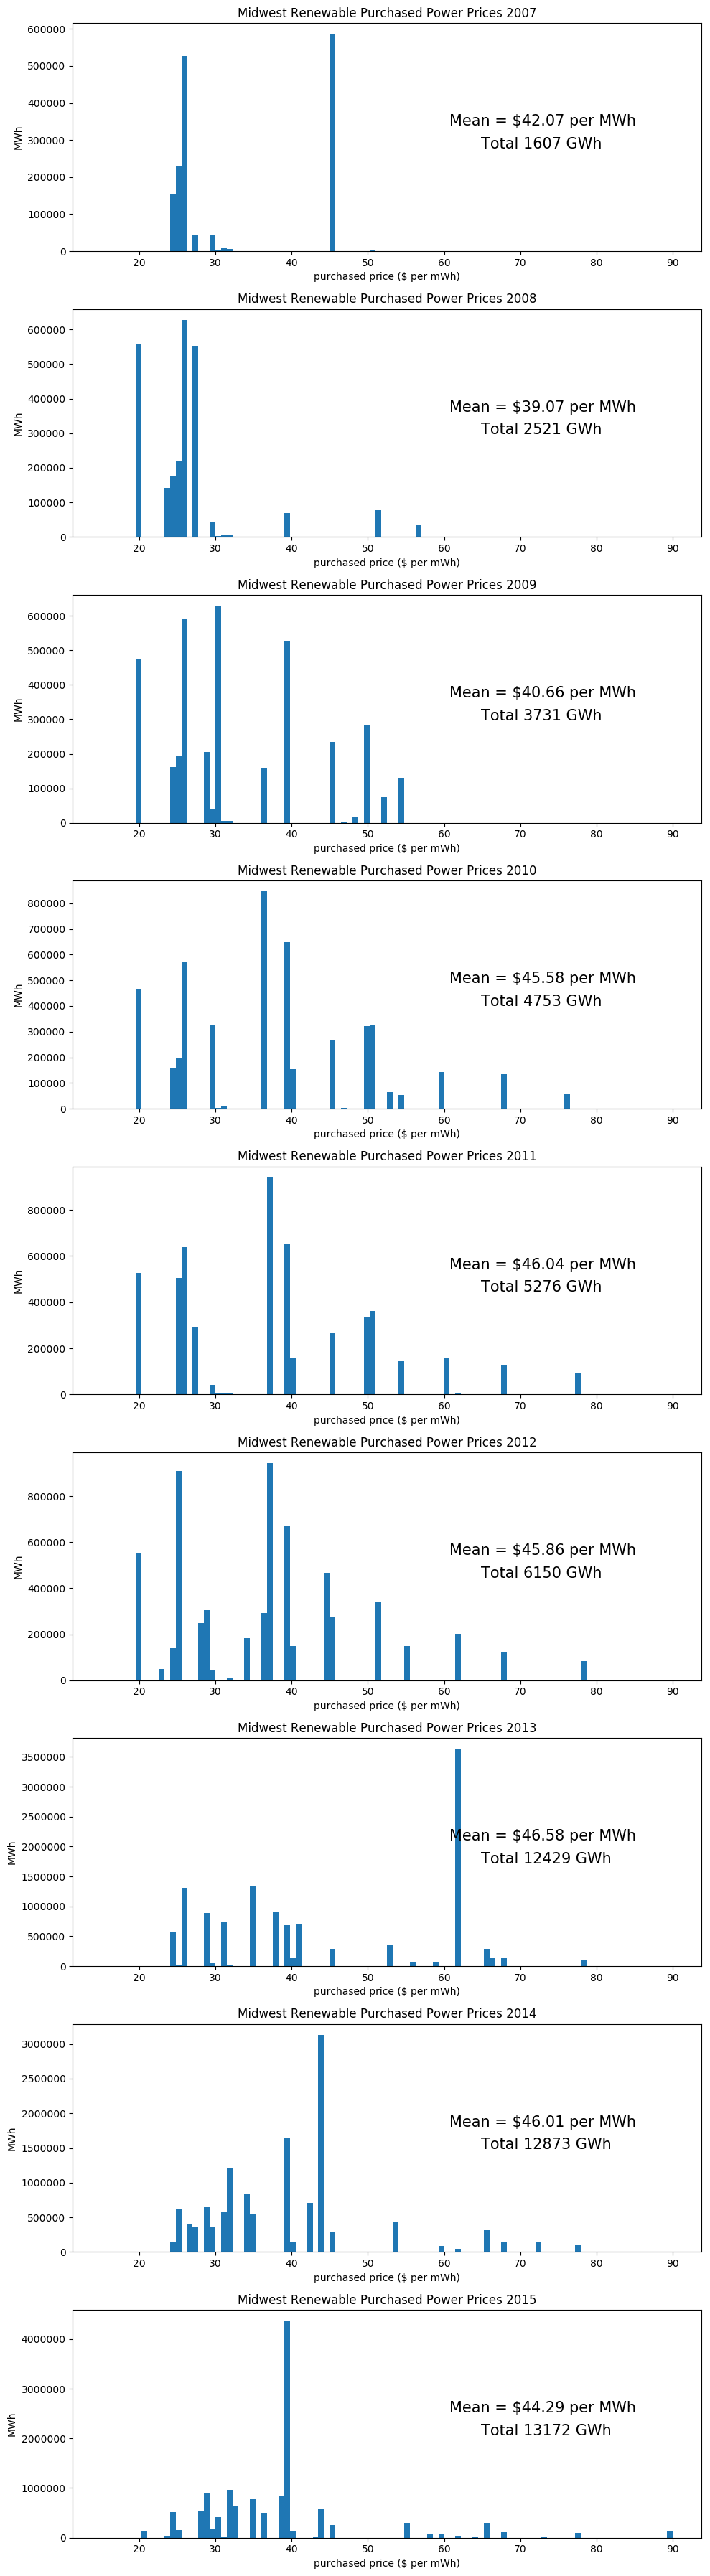

In [15]:
years = ppa_midwest.report_year.unique()
f, axarr = plt.subplots(len(years), dpi=100)
f.set_figwidth(10)
f.set_figheight(4*len(years))
for year, ax in zip(years, axarr):
    yearly_cost = renew_midwest.calculated_cost_per_mwh[renew_midwest.report_year == year]
    yearly_mwh = renew_midwest.mwh_purchased[renew_midwest.report_year == year]
    ax.text(.6, .55, 'Mean = ${:.2f} per MWh'.format(yearly_cost.mean()), transform=ax.transAxes, size=15)
    ax.text(.65, .45, 'Total {:.0f} GWh'.format(yearly_mwh.sum()/1000), transform=ax.transAxes, size=15)
    ax.hist(yearly_cost,
            bins=100, range=(15,90), weights=yearly_mwh)
    ax.set_xlabel('purchased price ($ per mWh)')
    ax.set_ylabel('MWh')
    ax.set_title('Midwest Renewable Purchased Power Prices {}'.format(year))
plt.tight_layout()